In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Cluster Dynamism -- (Heatmaps and Interpretations) ##DONE

1. Extend Cluster Dynamism to deaths data - till 6th May

  Heatmap of normalised cases, abs cases, normalised deaths, abs deaths, comparison of 1st and 2nd wave through differences ## DONE
  
2. Collect Beds Data - Chhatisgarh, Delhi, Rajasthan and Andhra Pradesh & Get active cases time series for these states ##DONE

3. Check the format of springer

### HEATMAP - DEATHS (norm denorm) DAILY (norm denorm) CompareWaves + Active Cases normalised by total beds

In [ ]:
!pip install tslearn
import math
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
from tslearn.metrics import dtw, dtw_path
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics
from scipy.spatial import distance
import numpy as np
from tslearn.metrics import dtw, dtw_path
from tslearn.clustering import TimeSeriesKMeans
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
from scipy.cluster.hierarchy import fcluster
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
from matplotlib.dates import DateFormatter
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy.cluster import hierarchy
from scipy.optimize import linear_sum_assignment

     |████████████████████████████████| 798kB 3.9MB/s 


/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning:

Scikit-learn <0.24 will be deprecated in a future release of tslearn



# Case Rate Clusters for States and UTs of India

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Covid19ClusterPrediction/cleaned_csv.csv")
del df['Status-C']
del df['Status-R']
del df['Status-D']
del df['Status-T']
del df['UN-C']
del df['UN-R']
del df['UN-D']
del df['UN-T']
del df['DD-C']
del df['DD-R']
del df['DD-D']
del df['DD-T']
del df['Unnamed: 0']
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
del df['Date']
cols=list(df.columns)
df.tail()


,TT-C,TT-R,TT-D,TT-T,AN-C,AN-R,AN-D,AN-T,AP-C,AP-R,AP-D,AP-T,AR-C,AR-R,AR-D,AR-T,AS-C,AS-R,AS-D,AS-T,BR-C,BR-R,BR-D,BR-T,CH-C,CH-R,CH-D,CH-T,CT-C,CT-R,CT-D,CT-T,DN-C,DN-R,DN-D,DN-T,DL-C,DL-R,DL-D,DL-T,...,PY-C,PY-R,PY-D,PY-T,PB-C,PB-R,PB-D,PB-T,RJ-C,RJ-R,RJ-D,RJ-T,SK-C,SK-R,SK-D,SK-T,TN-C,TN-R,TN-D,TN-T,TG-C,TG-R,TG-D,TG-T,TR-C,TR-R,TR-D,TR-T,UP-C,UP-R,UP-D,UP-T,UT-C,UT-R,UT-D,UT-T,WB-C,WB-R,WB-D,WB-T
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-02,370090,300004,3423,0,38,25,1,0,23920,11411,83,0,102,83,0,0,2385,2831,30,0,13534,11694,97,0,860,483,7,0,11825,12358,199,0,161,260,0,0,20394,24444,407,0,...,1360,987,16,0,7280,5244,157,0,18298,11262,159,0,230,68,1,0,20768,17576,153,0,7430,5567,56,0,247,41,0,0,30857,36650,288,0,5606,2935,71,0,17515,15587,92,0
2021-05-03,355769,318910,3439,0,66,52,1,0,18972,10227,71,0,220,90,0,0,4489,2534,29,0,11407,13603,82,0,890,528,11,0,15274,14398,266,0,119,226,0,0,18043,20293,448,0,...,799,790,15,0,6772,6016,155,0,17296,11949,154,0,27,100,1,0,20952,18016,122,0,5695,6206,49,0,134,62,1,0,29052,38687,285,0,5403,3344,128,0,17501,15937,98,0
2021-05-04,382847,337699,3786,0,31,29,0,0,20034,12207,82,0,234,138,0,0,4475,2851,41,0,14794,11926,105,0,780,542,11,0,15785,12093,210,0,192,229,0,0,19953,18788,338,0,...,1138,886,17,0,7514,6115,173,0,16974,14146,154,0,230,22,1,0,21228,19112,144,0,6876,7432,59,0,271,87,1,0,25770,38683,351,0,7028,5696,85,0,17639,16547,107,0
2021-05-05,412624,330718,3979,0,42,49,1,0,22204,11128,85,0,220,76,0,0,4826,2916,55,0,14836,11726,61,0,817,610,14,0,15157,10152,253,0,170,228,0,0,20960,19209,311,0,...,1819,933,18,0,7953,6701,180,0,16815,17022,155,0,221,89,4,0,23310,20062,167,0,6361,8126,51,0,240,59,0,0,31111,40852,353,0,7783,4757,127,0,18102,17073,103,0
2021-05-06,414280,328301,3923,0,32,30,1,0,21954,10141,72,0,222,139,0,0,4936,2976,46,0,15126,13364,90,0,759,693,9,0,13846,11600,212,0,163,136,0,0,19133,20028,335,0,...,1510,779,18,0,8841,5126,154,0,17532,16044,161,0,264,50,3,0,24898,21546,195,0,6026,6551,52,0,300,75,3,0,26622,28902,350,0,8517,4548,151,0,18431,17412,117,0


In [ ]:
current_ds=df[list(cols[i] for i in filter(lambda i:i%4==0, range(len(cols))))]
recovered_ds=df[list(cols[i] for i in filter(lambda i:i%4==1, range(len(cols))))]
deceased_ds=df[list(cols[i] for i in filter(lambda i:i%4==2, range(len(cols))))]

In [ ]:
population = {
    "TT": 1210854977,
    "AN": 380581,
    "AP": 49577103,
    "AR": 1383727,
    "AS": 31205576,
    "BR": 104099452,
    "CH": 1055450,
    "CT": 25545198,
    "DN": 585764,
    "DL": 16787941,
    "GA": 1458545,
    "GJ": 60439692,
    "HR": 25351462,
    "HP": 6864602,
    "JK": 12267032,
    "JH": 32988134,
    "KA": 61095297,
    "KL": 33406061,
    "LA": 274000,
    "LD": 64473,
    "MP": 72626809,
    "MH": 112374333,
    "MN": 2570390,
    "ML": 2966889,
    "MZ": 1097206,
    "NL": 1978502,
    "OR": 41974219,
    "PY": 1247953,
    "PB": 27743338,
    "RJ": 68548437,
    "SK": 610577,
    "TN": 72147030,
    "TG": 35003674,
    "TR": 3673917,
    "UP": 199812341,
    "UT": 10086292,
    "WB": 91276115
}
beds = {
    "TT": 1899228,
    "AN": 1294,
    "AP": 83230,
    "AR": 2624,
    "AS": 24178,
    "BR": 30857,
    "CH": 5631,
    "CT": 17430,
    "DN": 2191,
    "DL": 39455,
    "GA": 4584,
    "GJ": 64862,
    "HR": 36141,
    "HP": 16040,
    "JK": 7995,
    "JH": 26496,
    "KA": 262109,
    "KL": 99227,
    "LA": 1500,
    "LD": 426,
    "MP": 64939,
    "MH": 231739,
    "MN": 1790,
    "ML": 5244,
    "MZ": 2496,
    "NL": 2561,
    "OR": 25650,
    "PY": 5172,
    "PB": 60997,
    "RJ": 93176,
    "SK": 1952,
    "TN": 155375,
    "TG": 99919,
    "TR": 4667,
    "UP": 281402,
    "UT": 23843,
    "WB": 113535
}
name_to_code = {
    "Andaman and Nicobar Islands":"AN",
    "Andhra Pradesh":"AP",
    "Arunachal Pradesh":"AR",
    "Assam":"AS",
    "Bihar":"BR",
    "Chandigarh":"CH",
    "Chhattisgarh":"CT",
    "Dadra and Nagar Haveli and Daman and Diu":"DN",
    "Delhi":"DL",
    "Goa":"GA",
    "Gujarat":"GJ",
    "Haryana":"HR",
    "Himachal Pradesh":"HP",
    "Jammu and Kashmir":"JK",
    "Jharkhand":"JH",
    "Karnataka":"KA",
    "Kerala":"KL",
    "Ladakh":"LA",
    "Madhya Pradesh":"MP",
    "Maharashtra":"MH",
    "Manipur":"MN",
    "Meghalaya":"ML",
    "Mizoram":"MZ",
    "Nagaland":"NL",
    "Odisha":"OR",
    "Puducherry":"PY",
    "Punjab":"PB",
    "Rajasthan":"RJ",
    "Sikkim":"SK",
    "Tamil Nadu":"TN",
    "Telangana":"TG",
    "Tripura":"TR",
    "Uttar Pradesh":"UP",
    "Uttarakhand":"UT",
    "West Bengal":"WB",
    "Lakshwadeep":"LD",
    "India":"TT"
}
code_to_name = {v: k for k, v in name_to_code.items()}

## Computing the DTW Score Matrix and the dendrogram using Complete Linkage

In [ ]:
def getDTWPath_and_Score(dataset):
  cols=list(dataset.columns)
  pathDs=pd.DataFrame(columns=cols)
  scoreDs=pd.DataFrame(columns=cols)
  pathDs['Names']=[]
  scoreDs['Names']=[]
  # print(scoreDs)
  for i in range(len(cols)):
    path_list=[]
    score_list=[]
    for j in range(len(cols)):
      optimal_path, dtw_score = dtw_path(dataset[cols[i]], dataset[cols[j]], sakoe_chiba_radius=7)  # ADDITIONAL CONSTRAINT
      path_list.append(optimal_path)
      score_list.append(dtw_score)
    path_list.append(cols[i])
    score_list.append(cols[i])
    # print(score_list)
    pathDs.loc[len(pathDs.index)]=path_list
    scoreDs.loc[len(scoreDs.index)]=score_list
    # print(scoreDs)
  return pathDs,scoreDs

In [ ]:
def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(dist_mat)
    if method == 'single':
        Z = single(dist_mat)
    if method == 'average':
        Z = average(dist_mat)
    if method == 'ward':
        Z = ward(dist_mat)
    fig, ax = plt.subplots()
    fig.canvas.draw()
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()

    return Z,ax.get_xticklabels(),dn

In [ ]:
# Normalising the data first
normalised_ds=current_ds.astype(float)
normalised_deaths=deceased_ds.astype(float)
for j in normalised_ds.columns:
  val=beds[j[:2]]
  for i in range(len(normalised_ds)):
    normalised_ds.iloc[i][j]/=val
    normalised_deaths.iloc[i][j[:-2]+str("-D")]/=val
normalised_ds["MH-C"]["2020-12-16"]=5.26276761082088e-05 #Problem with data -ve value

In [ ]:
# Normalising the data first
normalised_ds=current_ds.astype(float)
normalised_deaths=deceased_ds.astype(float)
for j in normalised_ds.columns:
  val=population[j[:2]]
  for i in range(len(normalised_ds)):
    normalised_ds.iloc[i][j]/=val
    normalised_deaths.iloc[i][j[:-2]+str("-D")]/=val
normalised_ds["MH-C"]["2020-12-16"]=5.26276761082088e-05 #Problem with data -ve value

In [ ]:
normalised_deaths=deceased_ds.astype(float)
normalised_ds=current_ds.astype(float)

In [ ]:
normalised_ds.columns = normalised_ds.columns.str.replace('-C', '')
normalised_deaths.columns = normalised_deaths.columns.str.replace('-D', '')

In [ ]:
def clusters_of_given_timerange(d1,d2,data,K):
  data=data[d1:d2]
  pathDs,scoreDs=getDTWPath_and_Score(data)
  scoreDs.index=scoreDs['Names']
  scoreDs.drop(labels='Names',axis=1,inplace=True)
  scoreDs.index.name=None
  linkage_matrix,labels,dn = hierarchical_clustering(scoreDs)
  rootnode, nodelist = hierarchy.to_tree(linkage_matrix, rd=True)
  #maxSize=maxSize*rootnode.get_count()
  clusters = createKClusters(rootnode,K)
  for c in clusters:
    print(c)
  return clusters

In [ ]:
def clusters_series(delta,ds,K):
  grid=[]
  for i in range(0,len(ds),delta):
    if(min(i+delta-1,len(ds)-1) <= i):
      continue
    clusters = clusters_of_given_timerange(i,min(i+delta-1,len(ds)),ds,K)
    data=ds[i:min(i+delta-1,len(ds))]
    ranking={}
    for j in range(0,len(clusters)):
      clusterSum=0
      for entity in clusters[j]:
        top5=data[num_to_code[entity]].nlargest(5)
        clusterSum+=sum(top5)
      clusterSum/=len(clusters[j])
      #mx=max(mx,sum(top5))
      ranking[clusterSum]=[]
      for entity in clusters[j]:
        ranking[clusterSum].append(num_to_code[entity])
    grid.append(ranking)
  return grid

In [ ]:
# Determine the value of k using a cost function through kmeans

def clusters_series(delta,normalised_ds,K,alpha):
  rss=[]
  for i in range(0,len(normalised_ds),delta):
    data=normalised_ds[i:min(i+delta-1,len(normalised_ds)-1)]
    km_dba = TimeSeriesKMeans(n_clusters=K, metric="dtw").fit(data.transpose())
    rss.append(km_dba.inertia_ + (alpha*math.log(K)))
  return sum(rss)

In [ ]:
normalised_ds[0:95]

,TT,AN,AP,AR,AS,BR,CH,CT,DN,DL,GA,GJ,HR,HP,JK,JH,KA,KL,LA,LD,MP,MH,MN,ML,MZ,NL,OR,PY,PB,RJ,SK,TN,TG,TR,UP,UT,WB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-14,6.689488e-08,0.000000,2.017060e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.169660e-07,0.000000,0.000000,5.522364e-07,0.000000e+00,1.630386e-07,0.000000e+00,9.820723e-08,5.687591e-07,0.000000,0.0,0.000000,1.245836e-07,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,3.604469e-08,4.376467e-08,0.000000,1.386058e-08,2.856843e-08,0.000000e+00,6.005635e-08,0.000000e+00,0.000000e+00
2020-03-15,2.229829e-08,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.496734e-07,0.000000,0.0,0.000000,1.601789e-07,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.458822e-08,0.000000,0.000000e+00,5.713686e-08,0.000000e+00,5.004696e-09,0.000000e+00,0.000000e+00
2020-03-16,1.238794e-08,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,8.151931e-08,0.000000e+00,1.636787e-08,8.980406e-08,0.000000,0.0,0.000000,5.339298e-08,0.000000,0.0,0.000000,0.000000,2.382415e-08,8.013122e-07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.856843e-08,0.000000e+00,0.000000e+00,9.914446e-08,0.000000e+00
2020-03-17,9.084490e-09,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.956657e-08,0.000000,0.000000,3.944546e-08,0.000000e+00,0.000000e+00,0.000000e+00,3.273574e-08,0.000000e+00,0.000000,0.0,0.000000,2.669649e-08,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.856843e-08,0.000000e+00,1.000939e-08,0.000000e+00,1.095577e-08
2020-03-18,3.055692e-08,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.191331e-07,0.000000,0.000000,3.944546e-08,0.000000e+00,8.151931e-08,0.000000e+00,8.183936e-08,0.000000e+00,0.000029,0.0,0.000000,2.669649e-08,0.000000,0.0,0.000000,0.000000,2.382415e-08,0.000000e+00,3.604469e-08,4.376467e-08,0.000000,1.386058e-08,2.285474e-07,0.000000e+00,1.000939e-08,9.914446e-08,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-12,9.337204e-06,0.000000,4.175315e-06,0.000014,0.000008,0.000001,0.000012,0.000002,0.000000,1.272938e-04,0.000032,0.000008,1.443704e-05,2.330798e-06,1.271701e-05,1.727894e-06,4.435693e-06,2.334906e-06,0.000380,0.0,0.000003,3.108361e-05,0.000007,0.0,0.000002,0.000013,2.668305e-06,4.807873e-06,3.568424e-06,3.355292e-06,0.000082,2.747168e-05,4.685222e-06,1.115975e-05,2.642479e-06,6.840968e-06,5.214946e-06
2020-06-13,9.942561e-06,0.000000,4.477874e-06,0.000004,0.000007,0.000002,0.000005,0.000004,0.000009,1.271151e-04,0.000041,0.000009,1.636986e-05,2.330798e-06,1.206486e-05,1.667266e-06,5.041305e-06,2.544448e-06,0.000723,0.0,0.000003,3.049629e-05,0.000025,0.0,0.000005,0.000004,5.360433e-06,1.041706e-05,2.775441e-06,4.857879e-06,0.000000,2.756870e-05,7.227813e-06,2.259169e-05,2.512357e-06,6.047812e-06,4.973919e-06
2020-06-14,9.418964e-06,0.000005,5.930157e-06,0.000002,0.000007,0.000002,0.000002,0.000005,0.000007,1.324760e-04,0.000028,0.000008,1.810546e-05,2.330798e-06,1.328765e-05,1.576324e-06,2.880745e-06,1.616473e-06,0.000409,0.0,0.000002,3.016703e-05,0.000004,0.0,0.000002,0.000005,4.431292e-06,1.442362e-05,2.775441e-06,4.274350e-06,0.000008,2.736079e-05,6.770718e-06,8.982239e-06,2.487334e-06,3.370912e-06,4.261794e-06


In [ ]:
# for alpha in range(4,10):
#   print("For alpha = ",alpha)
#   results=[]
#   for k in range(2,8):
#     result=clusters_series(30,normalised_ds,k,10**(-alpha))
#     results.append(result) #indices correspond to values of k
#   plt.plot(results)
#   plt.show()

In [ ]:
# results=[]
# for k in range(2,8):
#   result=clusters_series(30,normalised_ds,k,10**(-8.2))
#   results.append(result) #indices correspond to values of k
# plt.plot(results)

In [ ]:
def createKClusters(rootnode, K):
  clusters=[]
  def inOrder(root,li):
    if root is None:
      return
    if root.get_count()==1:
      li.append(root.get_id())
      return
    inOrder(root.left,li)
    inOrder(root.right,li)
  def helper(root,clusters,K):
    if root is None:
      return
    if root.get_count()<=1:
      return
    rootNodes=[]
    rootNodes.append(root)
    while (len(rootNodes)>0) and K>1:
      node=rootNodes[0]
      idx=0
      for i in range(1,len(rootNodes)):
        r=rootNodes[i]
        if r.get_count()>node.get_count():
          node=r
          idx=i
      del rootNodes[idx]
      rootNodes.append(node.left)
      rootNodes.append(node.right)
      K-=1
    for r in rootNodes:
      li=[]
      inOrder(r,li)
      clusters.append(li)
  helper(rootnode,clusters,K)
  return clusters
  # return an array of size 4 where each element is a list of members of that cluster

In [ ]:
#normalised_ds[53:188] #4th March to 6th May - 9 weeks second wave
# 14 may to 17 Sept - 18 weeks first wave
#normalised_ds

,TT,AN,AP,AR,AS,BR,CH,CT,DN,DL,GA,GJ,HR,HP,JK,JH,KA,KL,LA,LD,MP,MH,MN,ML,MZ,NL,OR,PY,PB,RJ,SK,TN,TG,TR,UP,UT,WB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-14,6.689488e-08,0.000000,2.017060e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.169660e-07,0.000000,0.000000,5.522364e-07,0.000000,1.630386e-07,0.000000,9.820723e-08,5.687591e-07,0.000000,0.000000,0.000000,1.245836e-07,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,3.604469e-08,4.376467e-08,0.000000,1.386058e-08,2.856843e-08,0.000000,6.005635e-08,0.000000e+00,0.000000e+00
2020-03-15,2.229829e-08,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,1.496734e-07,0.000000,0.000000,0.000000,1.601789e-07,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.458822e-08,0.000000,0.000000e+00,5.713686e-08,0.000000,5.004696e-09,0.000000e+00,0.000000e+00
2020-03-16,1.238794e-08,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,8.151931e-08,0.000000,1.636787e-08,8.980406e-08,0.000000,0.000000,0.000000,5.339298e-08,0.000000,0.000000,0.000000,0.000000,2.382415e-08,8.013122e-07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.856843e-08,0.000000,0.000000e+00,9.914446e-08,0.000000e+00
2020-03-17,9.084490e-09,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.956657e-08,0.000000,0.000000,3.944546e-08,0.000000,0.000000e+00,0.000000,3.273574e-08,0.000000e+00,0.000000,0.000000,0.000000,2.669649e-08,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.856843e-08,0.000000,1.000939e-08,0.000000e+00,1.095577e-08
2020-03-18,3.055692e-08,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.191331e-07,0.000000,0.000000,3.944546e-08,0.000000,8.151931e-08,0.000000,8.183936e-08,0.000000e+00,0.000029,0.000000,0.000000,2.669649e-08,0.000000,0.000000,0.000000,0.000000,2.382415e-08,0.000000e+00,3.604469e-08,4.376467e-08,0.000000,1.386058e-08,2.285474e-07,0.000000,1.000939e-08,9.914446e-08,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-02,3.056435e-04,0.000100,4.824808e-04,0.000074,0.000076,0.000130,0.000815,0.000463,0.000275,1.214801e-03,0.001392,0.000215,5.254924e-04,0.000357,2.911055e-04,0.000144,6.176089e-04,9.566827e-04,0.000511,0.001349,0.000174,5.040920e-04,0.000100,0.000108,0.000139,0.000109,1.909505e-04,1.089785e-03,2.624053e-04,2.669353e-04,0.000377,2.878566e-04,2.122634e-04,0.000067,1.544299e-04,5.558039e-04,1.918903e-04
2021-05-03,2.938164e-04,0.000173,3.826767e-04,0.000159,0.000144,0.000110,0.000843,0.000598,0.000203,1.074760e-03,0.001853,0.000212,5.082547e-04,0.000383,3.043116e-04,0.000209,7.273555e-04,7.786312e-04,0.000325,0.001086,0.000166,4.326700e-04,0.000141,0.000083,0.000067,0.000051,2.123685e-04,6.402485e-04,2.440946e-04,2.523179e-04,0.000044,2.904070e-04,1.626972e-04,0.000036,1.453964e-04,5.356775e-04,1.917369e-04
2021-05-04,3.161791e-04,0.000081,4.040978e-04,0.000169,0.000143,0.000142,0.000739,0.000618,0.000328,1.188532e-03,0.001929,0.000216,6.226860e-04,0.000557,3.790648e-04,0.000181,7.305145e-04,1.113271e-03,0.000894,0.002621,0.000168,4.616713e-04,0.000168,0.000114,0.000180,0.000134,1.957392e-04,9.118933e-04,2.708398e-04,2.476205e-04,0.000377,2.942325e-04,1.964365e-04,0.000074,1.289710e-04,6.967873e-04,1.932488e-04


In [ ]:
normalised_ds
first_wave=normalised_ds[69:188] # 22 May to 17 September - 18 weeks - 14 days clustering
second_wave=normalised_ds[356:] # 4th march to 6th may - 9 weeks - 7 days clustering and then difference

In [ ]:
first_wave.tail()

,TT,AN,AP,AR,AS,BR,CH,CT,DN,DL,GA,GJ,HR,HP,JK,JH,KA,KL,LA,LD,MP,MH,MN,ML,MZ,NL,OR,PY,PB,RJ,SK,TN,TG,TR,UP,UT,WB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-13,0.000077,0.000066,0.000192,0.000116,0.000041,0.000015,0.000425,0.000087,0.000034,0.000252,0.000279,0.000022,0.000100,0.000047,0.000137,0.000031,0.000162,0.000094,0.000186,0.0,0.000031,0.000201,0.000056,0.000037,0.000032,0.000010,0.000093,0.000311,0.000095,0.000025,0.000051,0.000079,0.000063,0.000171,0.000031,0.000162,0.000035
2020-09-14,0.000068,0.000029,0.000160,0.000127,0.000077,0.000011,0.000241,0.000131,0.000041,0.000192,0.000210,0.000022,0.000098,0.000054,0.000100,0.000038,0.000135,0.000076,0.000270,0.0,0.000034,0.000152,0.000037,0.000047,0.000013,0.000066,0.000100,0.000315,0.000087,0.000025,0.000054,0.000080,0.000040,0.000069,0.000026,0.000103,0.000035
2020-09-15,0.000075,0.000045,0.000178,0.000122,0.000077,0.000015,0.000329,0.000135,0.000031,0.000254,0.000420,0.000022,0.000098,0.000060,0.000108,0.000052,0.000124,0.000096,0.000292,0.0,0.000032,0.000182,0.000093,0.000059,0.000036,0.000008,0.000087,0.000300,0.000086,0.000026,0.000088,0.000079,0.000059,0.000145,0.000034,0.000138,0.000035
2020-09-16,0.000081,0.000050,0.000178,0.000163,0.000077,0.000015,0.000347,0.000125,0.000046,0.000266,0.000431,0.000023,0.000106,0.000067,0.000130,0.000050,0.000159,0.000115,0.000131,0.0,0.000034,0.000208,0.000043,0.000053,0.000011,0.000017,0.000102,0.000409,0.000097,0.000026,0.000079,0.000078,0.000065,0.000124,0.000031,0.000153,0.000035
2020-09-17,0.000080,0.000029,0.000176,0.000115,0.000044,0.000015,0.000273,0.000149,0.000036,0.000264,0.000442,0.000023,0.000097,0.000058,0.000120,0.000031,0.000153,0.000130,0.000150,0.0,0.000033,0.000219,0.000043,0.000055,0.000024,0.000022,0.000101,0.000254,0.000103,0.000026,0.000087,0.000077,0.000062,0.000143,0.000030,0.000118,0.000035


/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:360: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



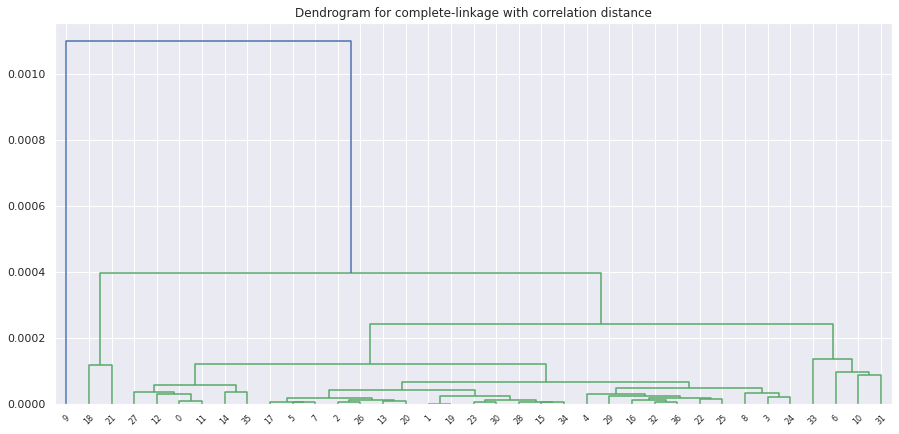

[9]
[18, 21]
[33, 6, 10, 31]
[27, 12, 0, 11, 14, 35]
[17, 5, 7, 2, 26, 13, 20, 1, 19, 23, 30, 28, 15, 34]
[4, 29, 16, 32, 36, 22, 25, 8, 3, 24]


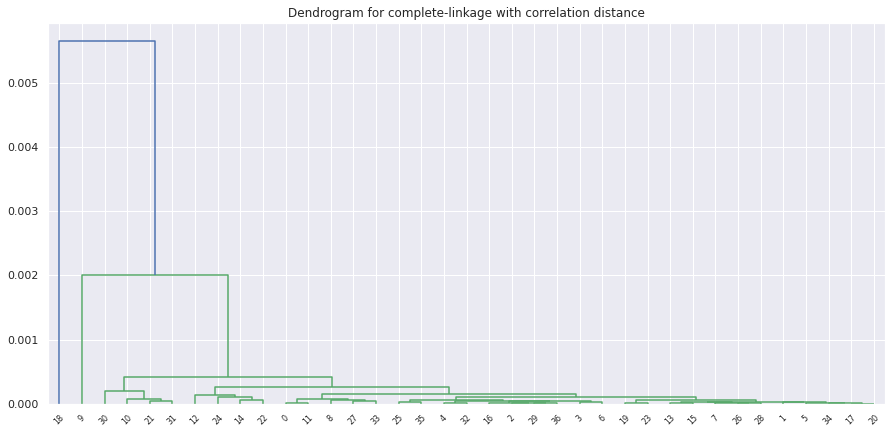

[18]
[9]
[30, 10, 21, 31]
[12, 24, 14, 22]
[0, 11, 8, 27, 33]
[25, 35, 4, 32, 16, 2, 29, 36, 3, 6, 19, 23, 13, 15, 7, 26, 28, 1, 5, 34, 17, 20]


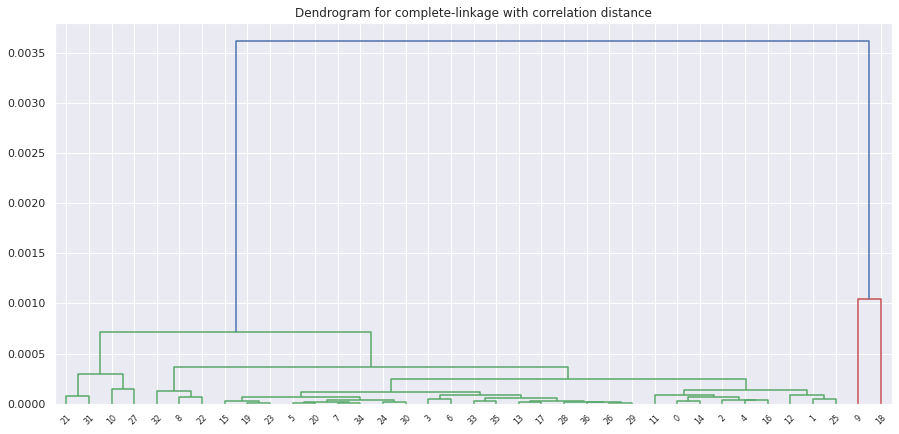

[9, 18]
[21, 31, 10, 27]
[32, 8, 22]
[11, 0, 14, 2, 4, 16, 12, 1, 25]
[15, 19, 23, 5, 20, 7, 34, 24, 30]
[3, 6, 33, 35, 13, 17, 28, 36, 26, 29]


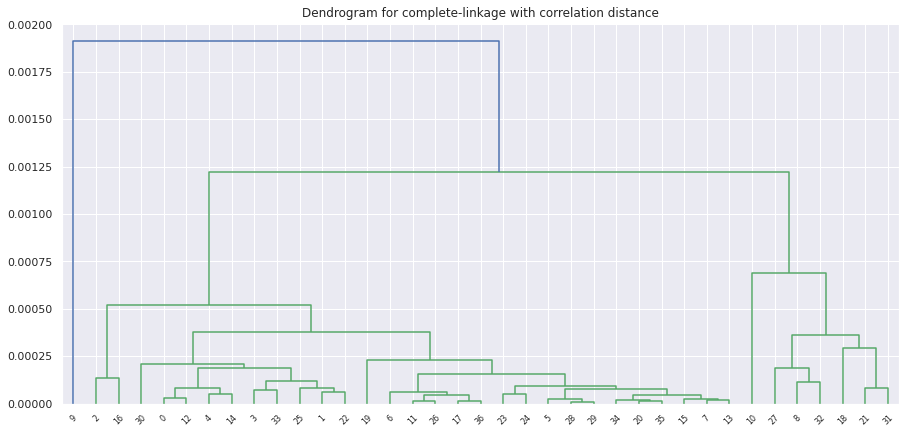

[9]
[10, 27, 8, 32, 18, 21, 31]
[2, 16]
[30, 0, 12, 4, 14, 3, 33, 25, 1, 22]
[19]
[6, 11, 26, 17, 36, 23, 24, 5, 28, 29, 34, 20, 35, 15, 7, 13]


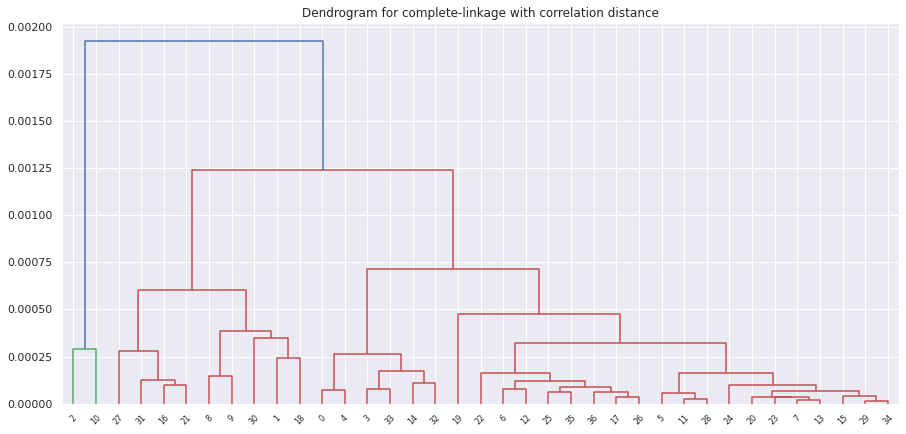

[2, 10]
[27, 31, 16, 21, 8, 9, 30, 1, 18]
[0, 4, 3, 33, 14, 32]
[19]
[22, 6, 12, 25, 35, 36, 17, 26]
[5, 11, 28, 24, 20, 23, 7, 13, 15, 29, 34]


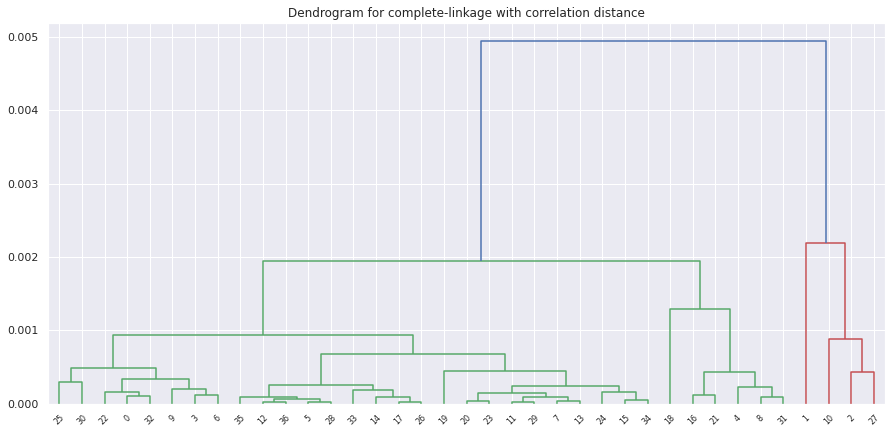

[1, 10, 2, 27]
[18, 16, 21, 4, 8, 31]
[25, 30, 22, 0, 32, 9, 3, 6]
[35, 12, 36, 5, 28, 33, 14, 17, 26]
[19]
[20, 23, 11, 29, 7, 13, 24, 15, 34]


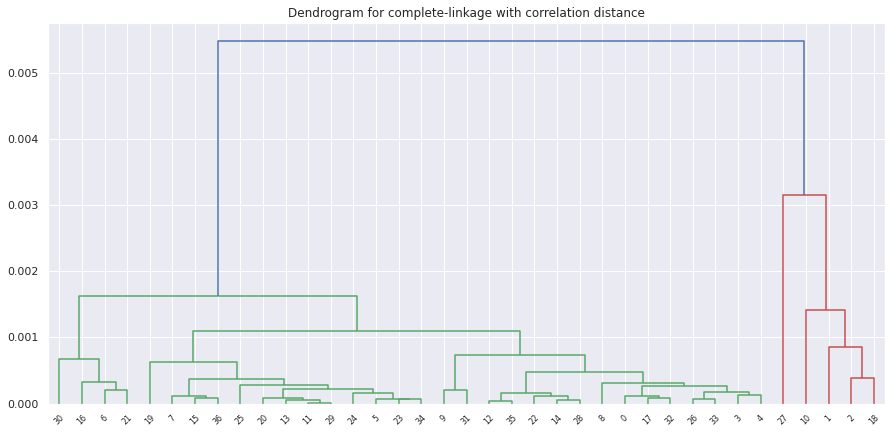

[27, 10, 1, 2, 18]
[30, 16, 6, 21]
[9, 31]
[12, 35, 22, 14, 28, 8, 0, 17, 32, 26, 33, 3, 4]
[19]
[7, 15, 36, 25, 20, 13, 11, 29, 24, 5, 23, 34]


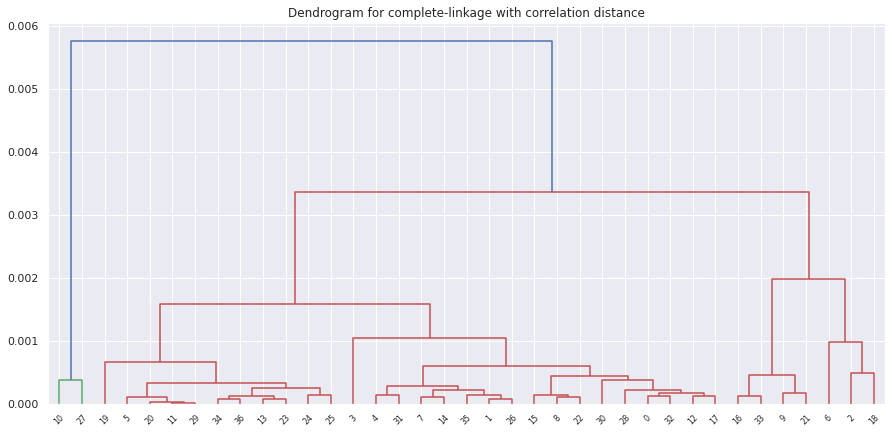

[10, 27]
[16, 33, 9, 21, 6, 2, 18]
[19, 5, 20, 11, 29, 34, 36, 13, 23, 24, 25]
[3]
[4, 31, 7, 14, 35, 1, 26]
[15, 8, 22, 30, 28, 0, 32, 12, 17]


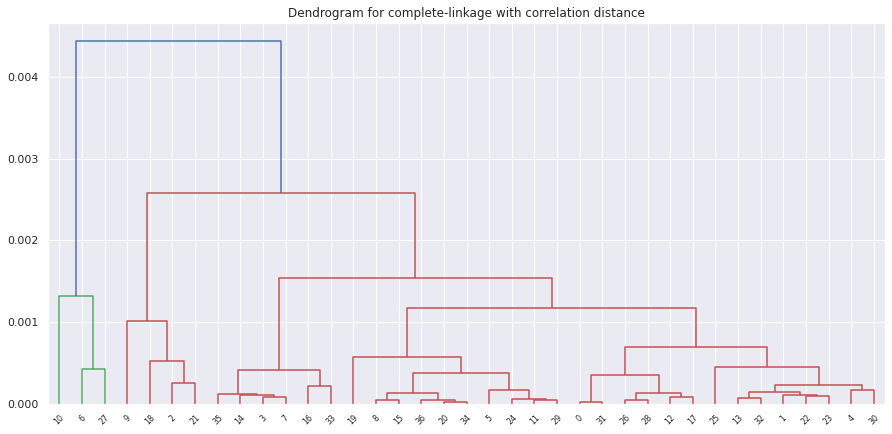

[10, 6, 27]
[9, 18, 2, 21]
[35, 14, 3, 7, 16, 33]
[19, 8, 15, 36, 20, 34, 5, 24, 11, 29]
[0, 31, 26, 28, 12, 17]
[25, 13, 32, 1, 22, 23, 4, 30]


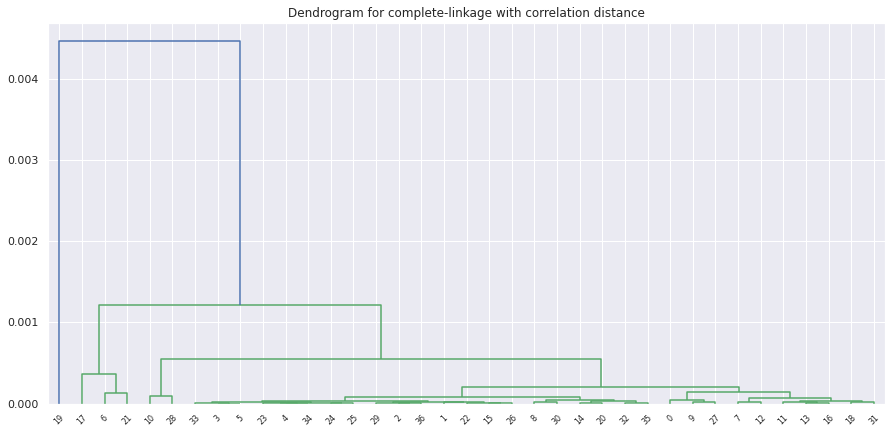

[19]
[17, 6, 21]
[10, 28]
[0, 9, 27, 7, 12, 11, 13, 16, 18, 31]
[33, 3, 5, 23, 4, 34, 24, 25, 29, 2, 36, 1, 22, 15, 26]
[8, 30, 14, 20, 32, 35]


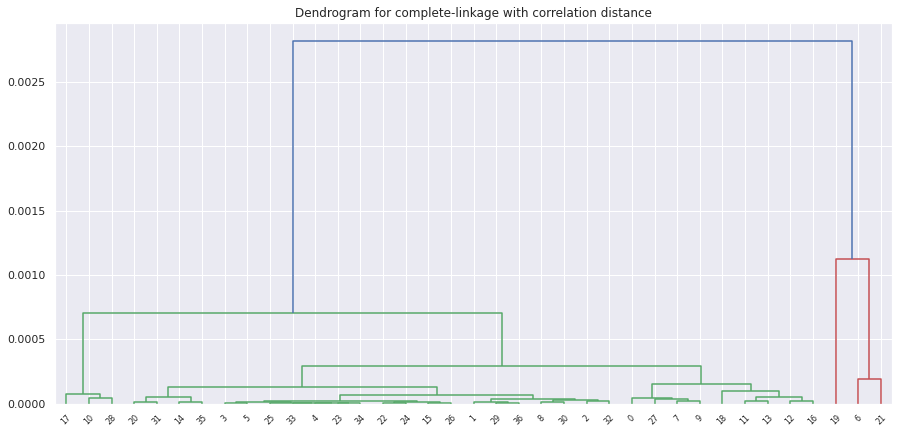

[19, 6, 21]
[17, 10, 28]
[0, 27, 7, 9, 18, 11, 13, 12, 16]
[20, 31, 14, 35]
[3, 5, 25, 33, 4, 23, 34, 22, 24, 15, 26]
[1, 29, 36, 8, 30, 2, 32]


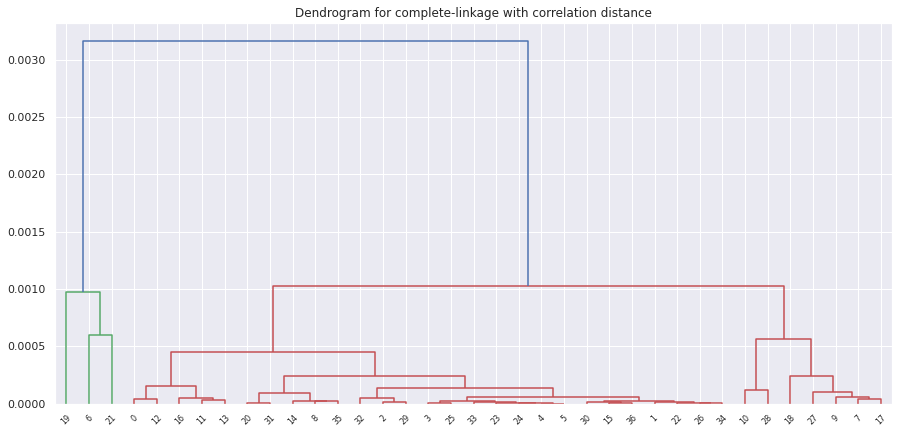

[19, 6, 21]
[10, 28, 18, 27, 9, 7, 17]
[0, 12, 16, 11, 13]
[20, 31, 14, 8, 35]
[32, 2, 29]
[3, 25, 33, 23, 24, 4, 5, 30, 15, 36, 1, 22, 26, 34]


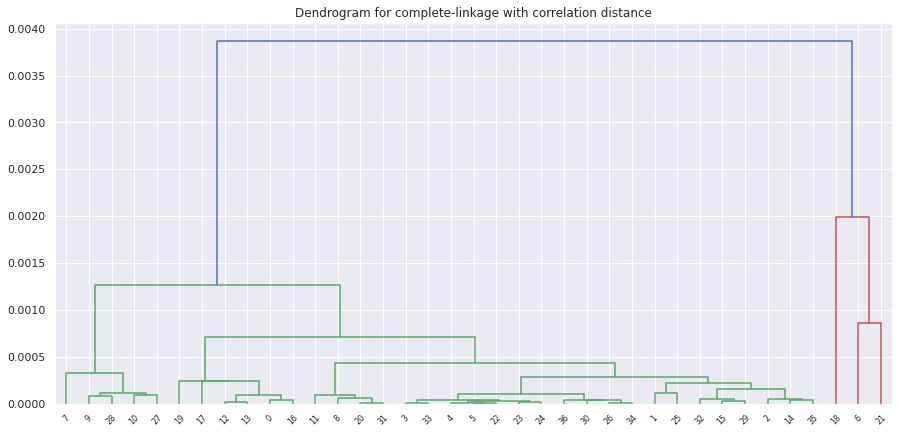

[18, 6, 21]
[7, 9, 28, 10, 27]
[19, 17, 12, 13, 0, 16]
[11, 8, 20, 31]
[3, 33, 4, 5, 22, 23, 24, 36, 30, 26, 34]
[1, 25, 32, 15, 29, 2, 14, 35]


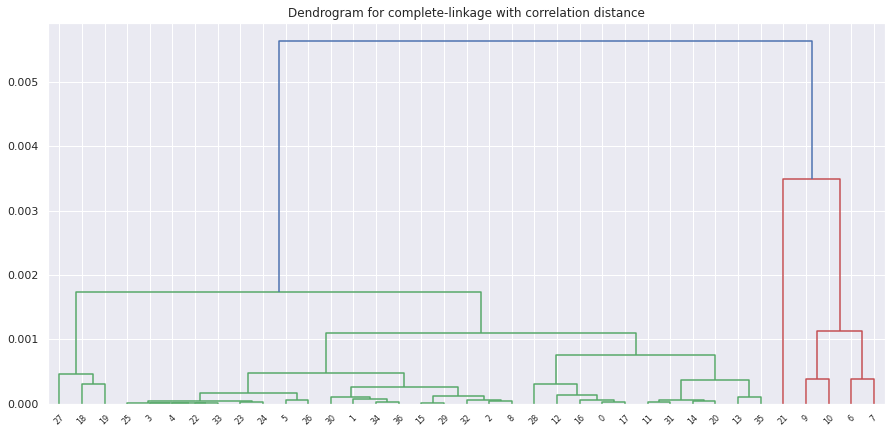

[21, 9, 10, 6, 7]
[27, 18, 19]
[25, 3, 4, 22, 33, 23, 24, 5, 26]
[30, 1, 34, 36, 15, 29, 32, 2, 8]
[28, 12, 16, 0, 17]
[11, 31, 14, 20, 13, 35]


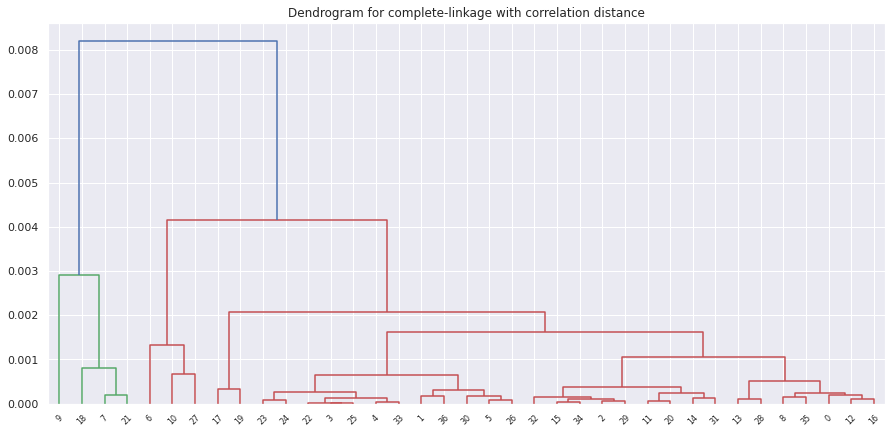

[9, 18, 7, 21]
[6, 10, 27]
[17, 19]
[23, 24, 22, 3, 25, 4, 33, 1, 36, 30, 5, 26]
[32, 15, 34, 2, 29, 11, 20, 14, 31]
[13, 28, 8, 35, 0, 12, 16]


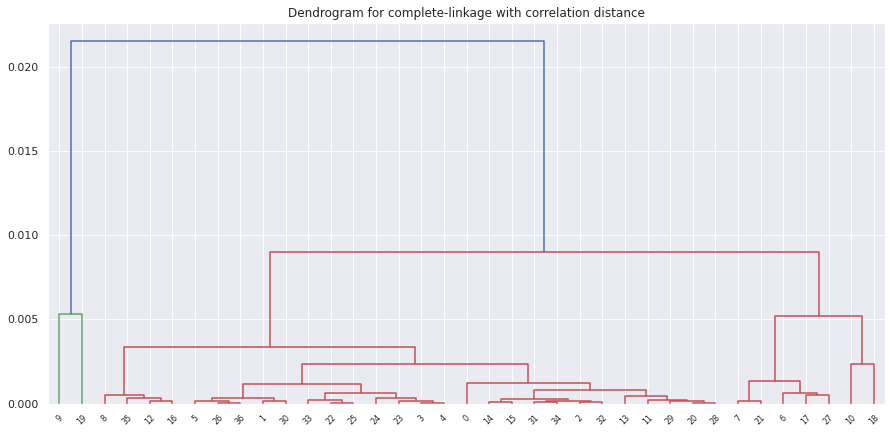

[9, 19]
[7, 21, 6, 17, 27, 10, 18]
[8, 35, 12, 16]
[0, 14, 15, 31, 34, 2, 32, 13, 11, 29, 20, 28]
[5, 26, 36, 1, 30]
[33, 22, 25, 24, 23, 3, 4]


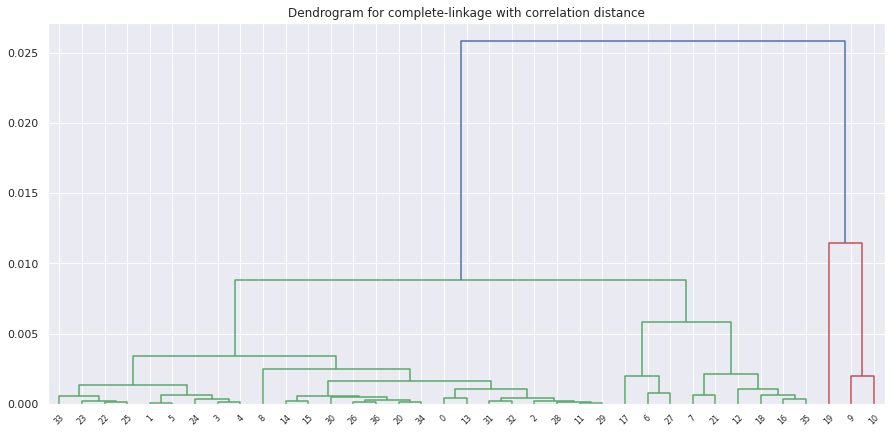

[19, 9, 10]
[17, 6, 27, 7, 21, 12, 18, 16, 35]
[33, 23, 22, 25, 1, 5, 24, 3, 4]
[8]
[14, 15, 30, 26, 36, 20, 34]
[0, 13, 31, 32, 2, 28, 11, 29]


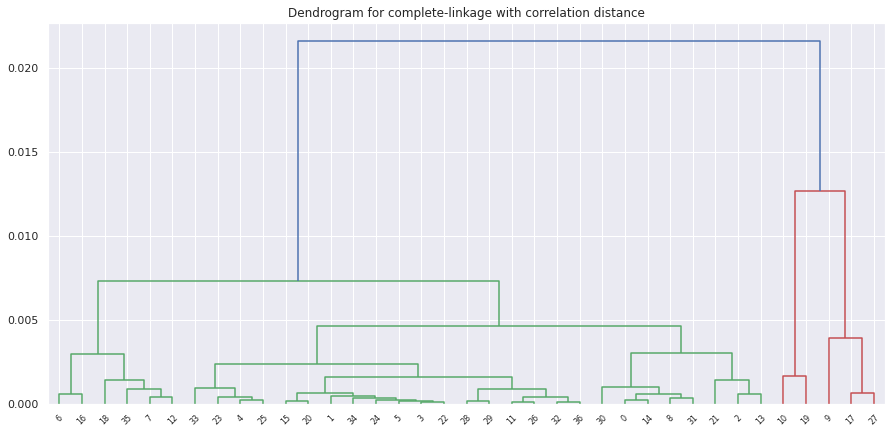

[10, 19, 9, 17, 27]
[6, 16, 18, 35, 7, 12]
[30, 0, 14, 8, 31, 21, 2, 13]
[33, 23, 4, 25]
[15, 20, 1, 34, 24, 5, 3, 22]
[28, 29, 11, 26, 32, 36]


In [ ]:
grid_fw = clusters_series(14,first_wave,6)
grid_sw = clusters_series(7,second_wave,6)


In [ ]:
table_fw = grid_to_table(grid_fw)
table_sw = grid_to_table(grid_sw)

In [ ]:
diff_waves = pd.DataFrame()
for state in table_fw.index:
  temp=[]
  for i in range(9):
    temp.append(table_fw[i][state] - table_sw[i][state])
  diff_waves[state]=temp

In [ ]:
diff_waves.transpose()

,0,1,2,3,4,5,6,7,8
LA,-2,-2,-1,1,0,1,-1,0,0
GA,0,1,0,0,0,-1,-1,0,0
DL,-3,-1,-1,-1,1,2,2,1,1
MH,0,2,1,1,1,1,0,0,-1
PY,0,2,0,0,0,-1,-1,-1,0
TN,-1,-1,-2,-2,-2,-3,-1,0,1
AP,0,1,-1,-2,-4,-4,-3,-2,-1
KA,1,3,1,0,-1,-2,-1,0,1
CH,1,5,4,4,3,1,0,0,-1
TR,-3,-1,-1,-2,-3,-2,-2,-4,-3


In [ ]:

table=diff_waves.transpose()
table['average_rank'] = table.mean(axis=1)
table = table.sort_values(by=['average_rank'], ascending=True)
del table['average_rank']
# plt.rcParams["figure.figsize"] = (30,14)
# sns.heatmap(table,cmap='YlOrRd_r')

In [ ]:
table

,0,1,2,3,4,5,6,7,8
TR,-3,-1,-1,-2,-3,-2,-2,-4,-3
AS,-1,0,-2,-2,-3,-4,-2,-2,-1
AR,-1,0,-1,-2,-3,-3,-2,-3,-2
AP,0,1,-1,-2,-4,-4,-3,-2,-1
MN,-1,-2,-3,-2,-2,-3,-2,-1,0
AN,0,1,-2,-1,-3,-5,-4,-2,0
NL,-1,0,-2,-1,-2,-3,-1,0,-1
TN,-1,-1,-2,-2,-2,-3,-1,0,1
SK,1,-2,0,-2,-3,-3,-3,0,2
OR,0,0,-1,-1,-2,-2,-1,-1,0


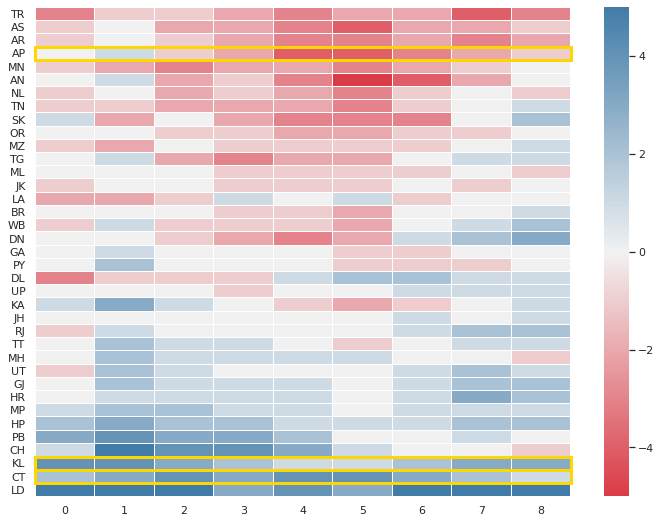

In [ ]:
fig=plt.figure(figsize=(12, 9))
sns.set()
rank = table
#rank = rank.rename(columns=months)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 240, as_cmap=True)
ax = sns.heatmap(rank, cmap=cmap,  linewidths=.01)
# this is the row we want to highlight (given as any general x, y pair)
start_index=[]
rect = plt.Rectangle([0,35],9,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
rect = plt.Rectangle([0,34],9,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
rect = plt.Rectangle([0,3],9,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
# plt.xticks(rotation=45)
plt.show()

In [ ]:
pathDs,scoreDs=getDTWPath_and_Score(normalised_ds)
scoreDs.index=scoreDs['Names']
scoreDs.drop(labels='Names',axis=1,inplace=True)
scoreDs.index.name=None

In [ ]:
num_to_code={}
for i in range(len(scoreDs.columns)):
  num_to_code[i]=scoreDs.columns[i]

In [ ]:
del normalised_deaths['TT']
del normalised_ds['TT']

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:360: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



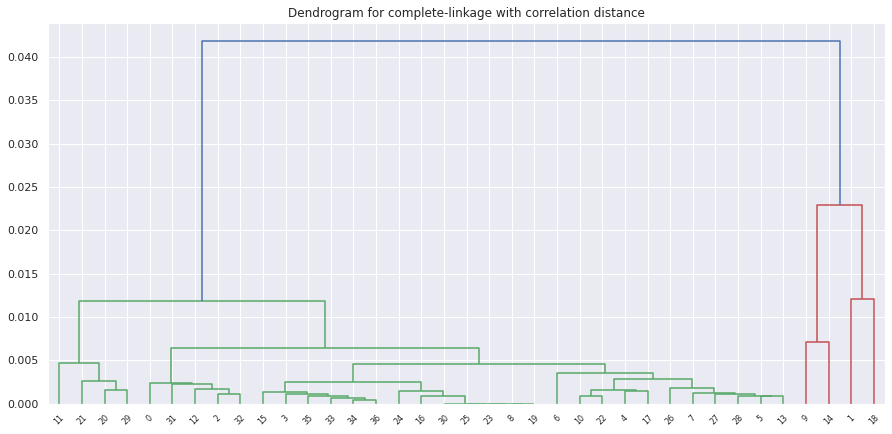

[9, 14, 1, 18]
[11, 21, 20, 29]
[0, 31, 12, 2, 32]
[6, 10, 22, 4, 17, 26, 7, 27, 28, 5, 13]
[15, 3, 35, 33, 34, 36]
[24, 16, 30, 25, 23, 8, 19]


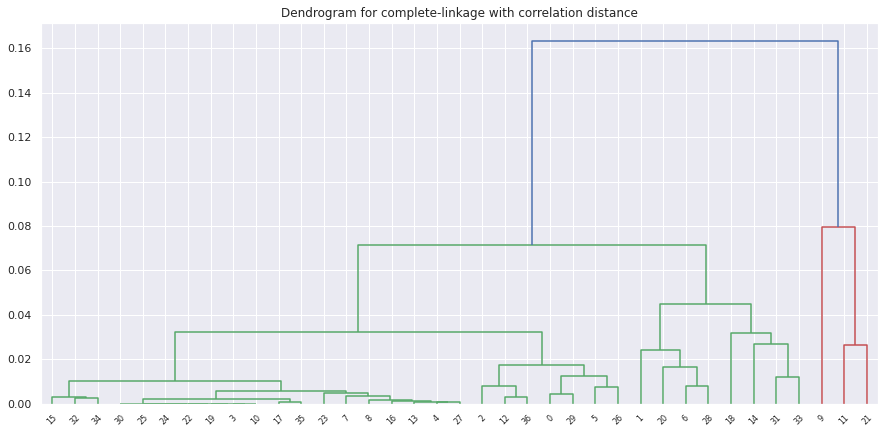

[9, 11, 21]
[1, 20, 6, 28, 18, 14, 31, 33]
[2, 12, 36, 0, 29, 5, 26]
[15, 32, 34]
[30, 25, 24, 22, 19, 3, 10, 17, 35]
[23, 7, 8, 16, 13, 4, 27]


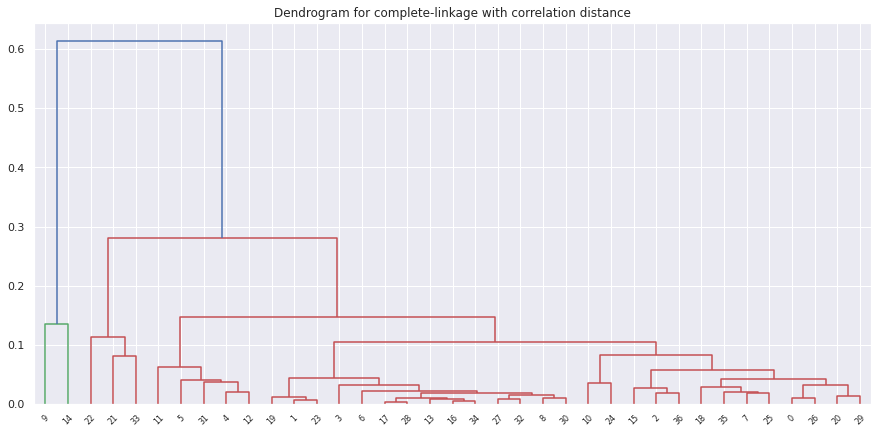

[9, 14]
[22, 21, 33]
[11, 5, 31, 4, 12]
[10, 24, 15, 2, 36, 18, 35, 7, 25, 0, 26, 20, 29]
[19, 1, 23]
[3, 6, 17, 28, 13, 16, 34, 27, 32, 8, 30]


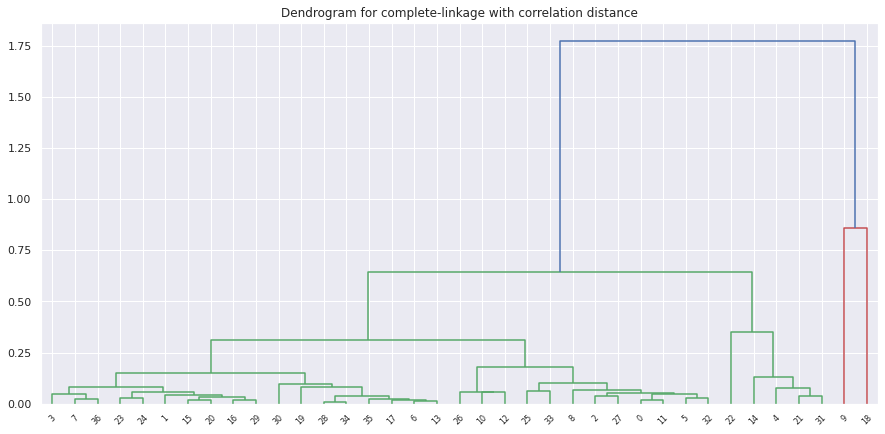

[9, 18]
[22, 14, 4, 21, 31]
[3, 7, 36, 23, 24, 1, 15, 20, 16, 29]
[30, 19, 28, 34, 35, 17, 6, 13]
[26, 10, 12]
[25, 33, 8, 2, 27, 0, 11, 5, 32]


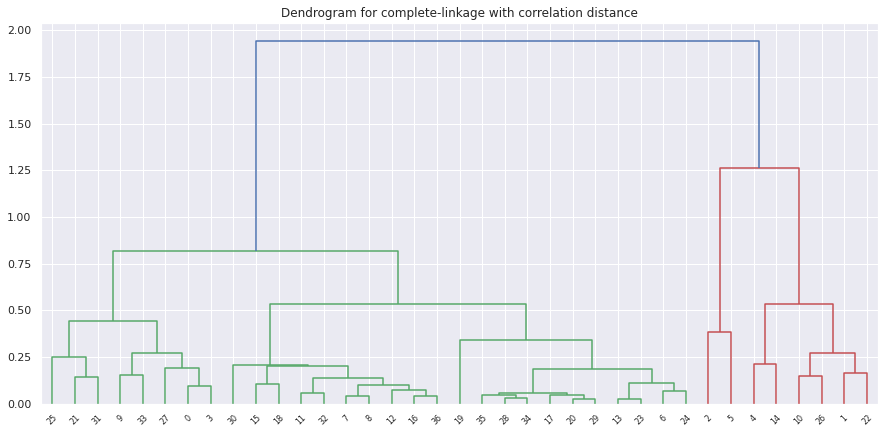

[2, 5, 4, 14, 10, 26, 1, 22]
[25, 21, 31, 9, 33, 27, 0, 3]
[19]
[35, 28, 34, 17, 20, 29, 13, 23, 6, 24]
[30]
[15, 18, 11, 32, 7, 8, 12, 16, 36]


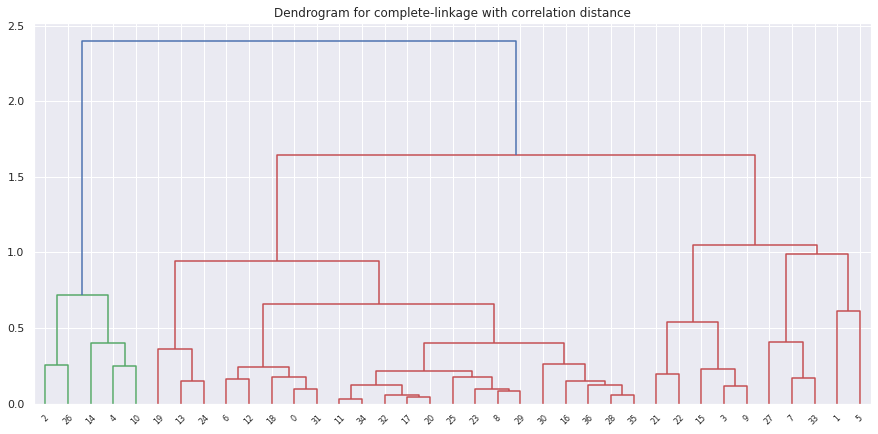

[2, 26, 14, 4, 10]
[21, 22, 15, 3, 9, 27, 7, 33, 1, 5]
[19, 13, 24]
[6, 12, 18, 0, 31]
[11, 34, 32, 17, 20, 25, 23, 8, 29]
[30, 16, 36, 28, 35]


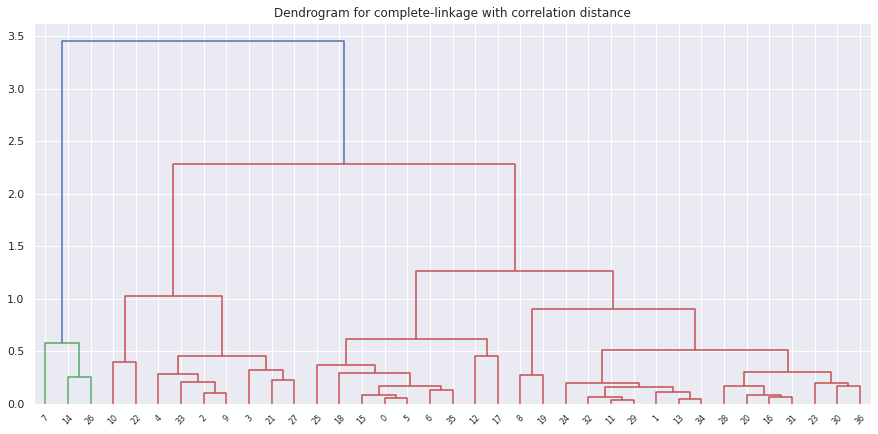

[7, 14, 26]
[10, 22, 4, 33, 2, 9, 3, 21, 27]
[25, 18, 15, 0, 5, 6, 35, 12, 17]
[8, 19]
[24, 32, 11, 29, 1, 13, 34]
[28, 20, 16, 31, 23, 30, 36]


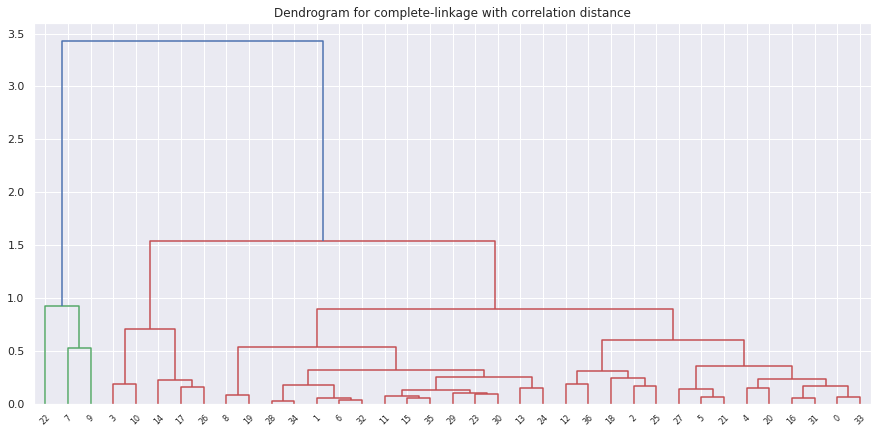

[22, 7, 9]
[3, 10, 14, 17, 26]
[8, 19]
[28, 34, 1, 6, 32, 11, 15, 35, 29, 23, 30, 13, 24]
[12, 36, 18, 2, 25]
[27, 5, 21, 4, 20, 16, 31, 0, 33]


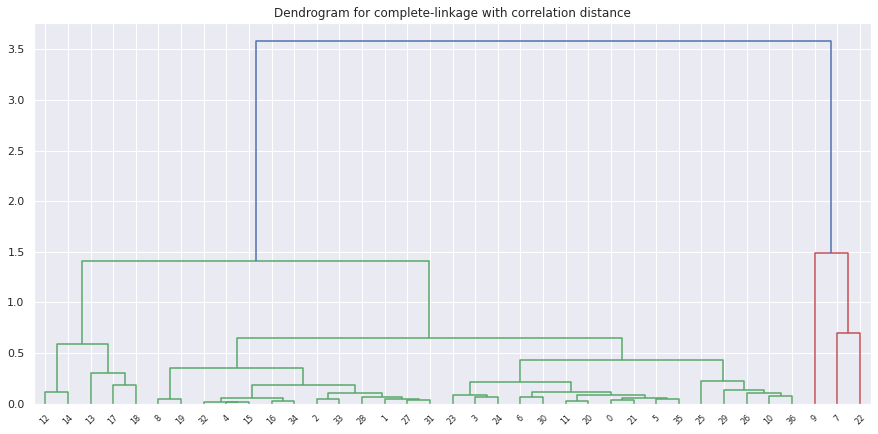

[9, 7, 22]
[12, 14, 13, 17, 18]
[23, 3, 24, 6, 30, 11, 20, 0, 21, 5, 35]
[25, 29, 26, 10, 36]
[8, 19]
[32, 4, 15, 16, 34, 2, 33, 28, 1, 27, 31]


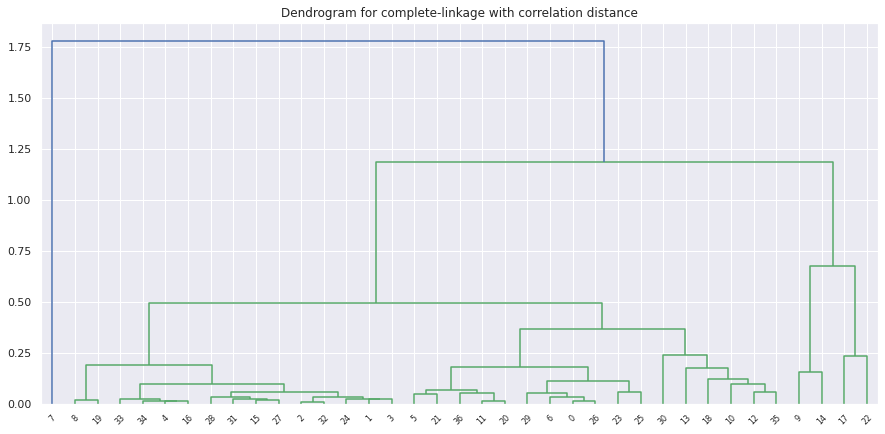

[7]
[9, 14, 17, 22]
[5, 21, 36, 11, 20, 29, 6, 0, 26, 23, 25]
[30, 13, 18, 10, 12, 35]
[8, 19]
[33, 34, 4, 16, 28, 31, 15, 27, 2, 32, 24, 1, 3]


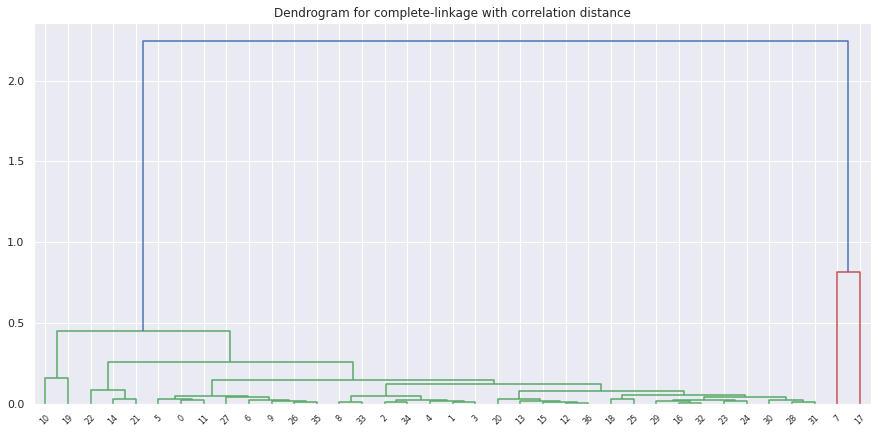

[7, 17]
[10, 19]
[22, 14, 21]
[5, 0, 11, 27, 6, 9, 26, 35]
[8, 33, 2, 34, 4, 1, 3]
[20, 13, 15, 12, 36, 18, 25, 29, 16, 32, 23, 24, 30, 28, 31]


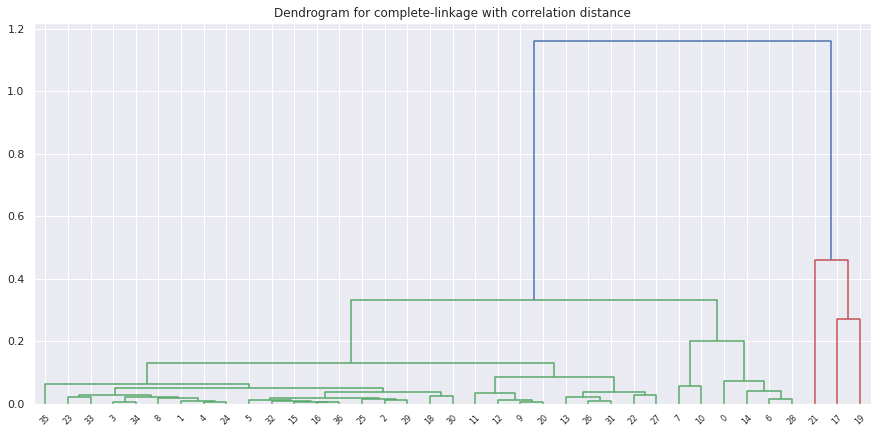

[21, 17, 19]
[7, 10, 0, 14, 6, 28]
[11, 12, 9, 20, 13, 26, 31, 22, 27]
[35]
[23, 33, 3, 34, 8, 1, 4, 24]
[5, 32, 15, 16, 36, 25, 2, 29, 18, 30]


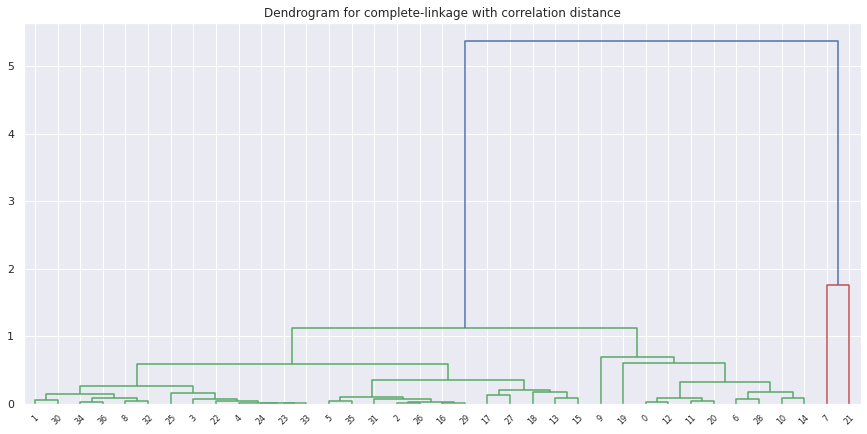

[7, 21]
[9, 19, 0, 12, 11, 20, 6, 28, 10, 14]
[1, 30, 34, 36, 8, 32]
[25, 3, 22, 4, 24, 23, 33]
[5, 35, 31, 2, 26, 16, 29]
[17, 27, 18, 13, 15]


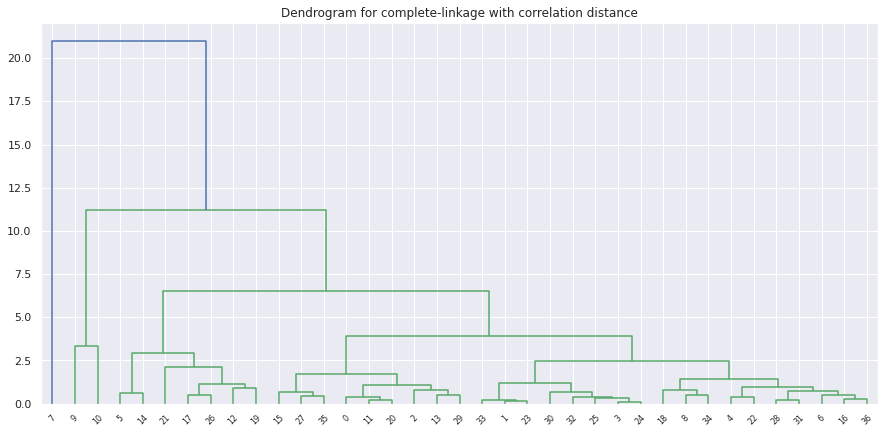

[7]
[9, 10]
[5, 14, 21, 17, 26, 12, 19]
[15, 27, 35, 0, 11, 20, 2, 13, 29]
[33, 1, 23, 30, 32, 25, 3, 24]
[18, 8, 34, 4, 22, 28, 31, 6, 16, 36]


In [ ]:
grid = clusters_series(30,normalised_ds,6)

In [ ]:
def grid_to_table(grid):
  table=pd.DataFrame()
  for k in grid[0]:
    for v in grid[0][k]:
      table[v]=[-1 for x in range(len(grid))]
  for i,g in enumerate(grid):
    sortedd=sorted(g,reverse=True)
    for j,k in enumerate(sortedd):
      for v in g[k]:
        table[v].iloc[i]=j+1
  table=table.transpose()
  table['average_rank'] = table.mean(axis=1)
  table = table.sort_values(by=['average_rank'], ascending=True)
  del table['average_rank']
  return table
  # replace v by code_to_name[v[:-2]] to get names instead of codes

In [ ]:
months={0:"Mar 20",1:"April 20",2:"May 20",3:"Jun 20",4:"Jul 20",5:"Aug 20",6:"Sept 20",7:"Oct 20",8:"Nov 20",9:"Dec 20",10:"Jan 21",11:"Feb 21",12:"Mar 21",13:"April 21"}

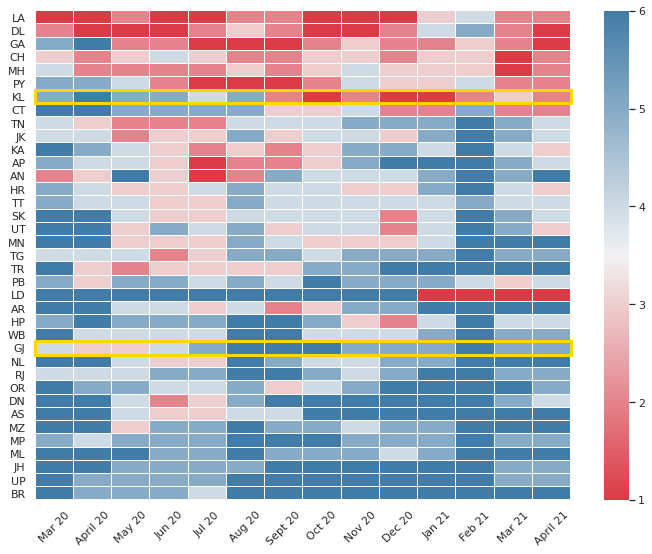

In [ ]:
fig=plt.figure(figsize=(12, 9))
sns.set()
rank = grid_to_table(grid)
rank = rank.rename(columns=months)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 240, as_cmap=True)
ax = sns.heatmap(rank, cmap=cmap,  linewidths=.01)
# this is the row we want to highlight (given as any general x, y pair)
start_index=[]
rect = plt.Rectangle([0,25],14,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
rect = plt.Rectangle([0,6],14,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
plt.xticks(rotation=45)
plt.show()

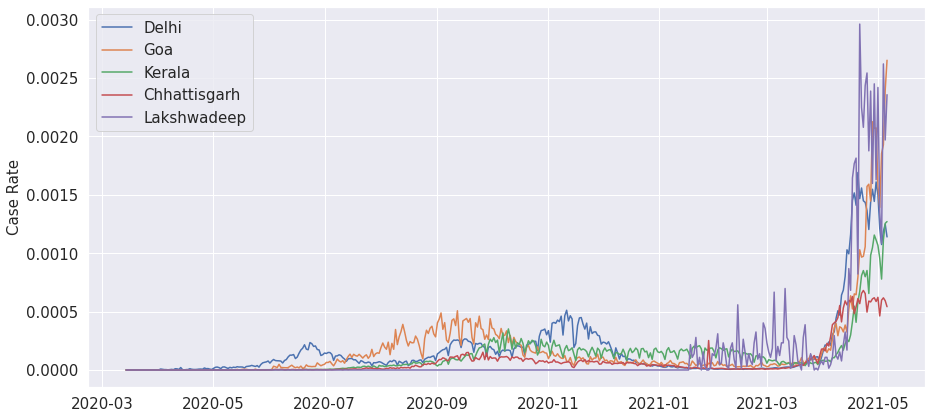

In [ ]:
#Delhi, Goa, Kerala, Chhattisgarh, Lakshdweep
plt.plot(normalised_ds["DL"],label="Delhi")
plt.plot(normalised_ds["GA"],label="Goa")
plt.plot(normalised_ds["KL"],label="Kerala")
plt.plot(normalised_ds["CT"],label="Chhattisgarh")
plt.plot(normalised_ds["LD"],label="Lakshwadeep")
plt.ylabel("Case Rate",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

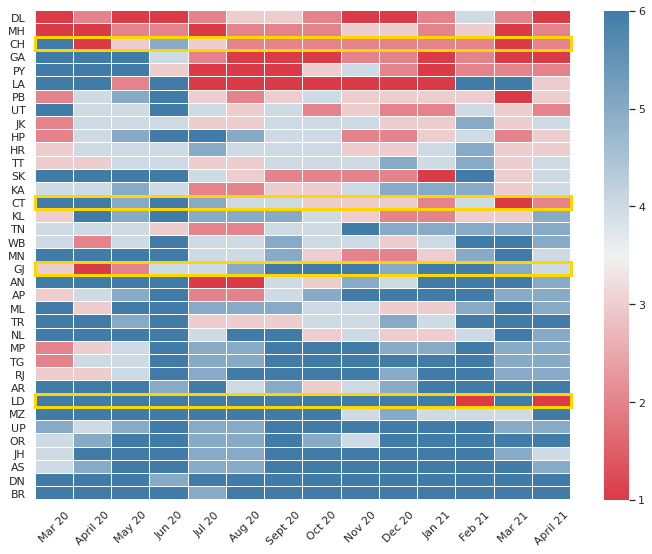

In [ ]:
fig=plt.figure(figsize=(12, 9))
sns.set()
rank = grid_to_table(grid)
rank = rank.rename(columns=months)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 240, as_cmap=True)
ax = sns.heatmap(rank, cmap=cmap,  linewidths=.01)
# this is the row we want to highlight (given as any general x, y pair)
start_index=[]
rect = plt.Rectangle([0,2],14,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
rect = plt.Rectangle([0,14],14,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
rect = plt.Rectangle([0,19],14,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
rect = plt.Rectangle([0,29],14,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
plt.xticks(rotation=45)
plt.show()

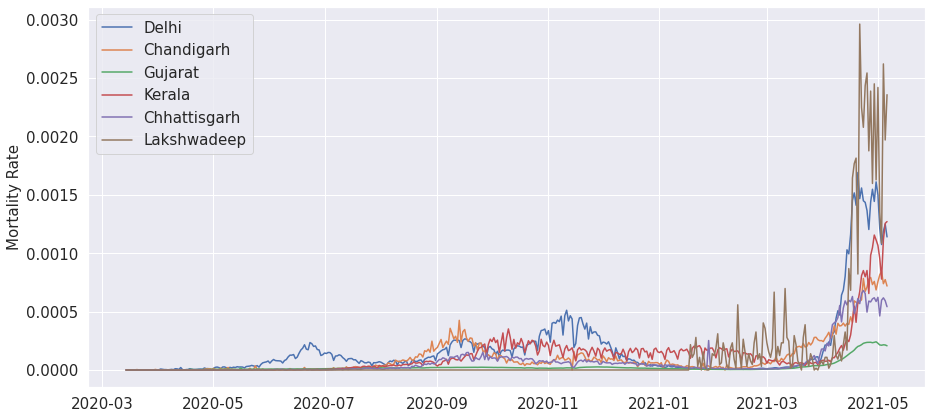

In [ ]:
#Delhi, Goa, Kerala, Chhattisgarh, Lakshdweep
plt.plot(normalised_ds["DL"],label="Delhi")
plt.plot(normalised_ds["CH"],label="Chandigarh")
plt.plot(normalised_ds["GJ"],label="Gujarat")
plt.plot(normalised_ds["KL"],label="Kerala")
plt.plot(normalised_ds["CT"],label="Chhattisgarh")
plt.plot(normalised_ds["LD"],label="Lakshwadeep")
plt.ylabel("Mortality Rate",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

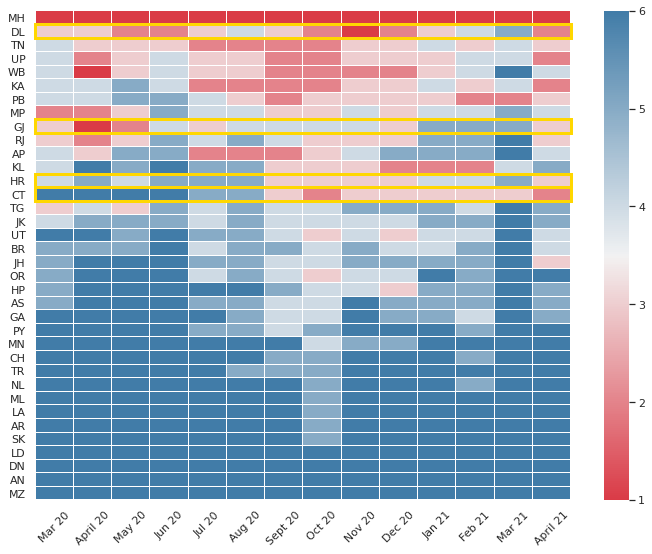

In [ ]:
fig=plt.figure(figsize=(12, 9))
sns.set()
rank = grid_to_table(grid)
rank = rank.rename(columns=months)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 240, as_cmap=True)
ax = sns.heatmap(rank, cmap=cmap,  linewidths=.01)
# this is the row we want to highlight (given as any general x, y pair)
start_index=[]
rect = plt.Rectangle([0,1],14,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
rect = plt.Rectangle([0,8],14,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
rect = plt.Rectangle([0,12],14,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
rect = plt.Rectangle([0,13],14,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
plt.xticks(rotation=45)
plt.show()

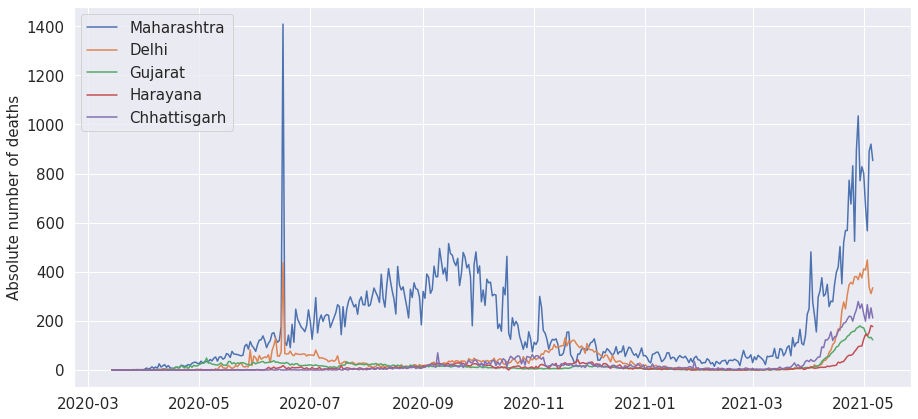

In [ ]:
#Delhi, Goa, Kerala, Chhattisgarh, Lakshdweep
plt.plot(normalised_deaths["MH"],label="Maharashtra")
plt.plot(normalised_deaths["DL"],label="Delhi")
plt.plot(normalised_deaths["GJ"],label="Gujarat")
plt.plot(normalised_deaths["HR"],label="Harayana")
plt.plot(normalised_deaths["CT"],label="Chhattisgarh")
plt.ylabel("Absolute number of deaths",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

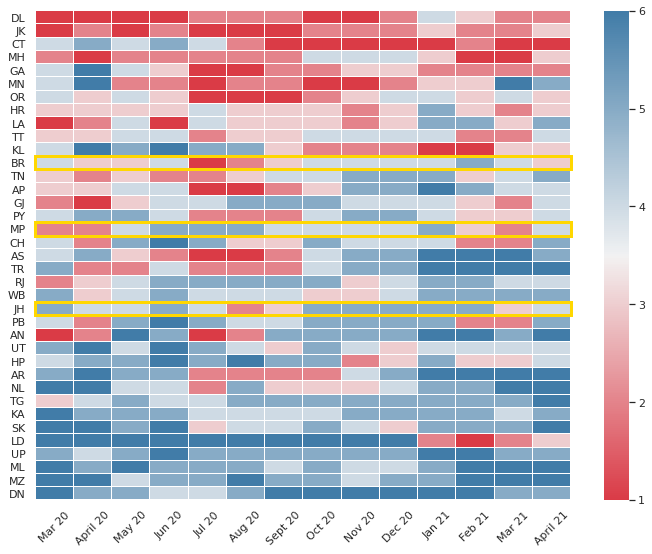

In [ ]:
fig=plt.figure(figsize=(12, 9))
sns.set()
rank = grid_to_table(grid)
rank = rank.rename(columns=months)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 240, as_cmap=True)
ax = sns.heatmap(rank, cmap=cmap,  linewidths=.01)
# this is the row we want to highlight (given as any general x, y pair)
start_index=[]
rect = plt.Rectangle([0,22],14,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
rect = plt.Rectangle([0,11],14,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
rect = plt.Rectangle([0,16],14,1, color="gold", linewidth=3, fill=False, clip_on=False)
ax.add_patch(rect)
plt.xticks(rotation=45)
plt.show()

## Hospital Beds Data -- Chhattisgarh, Delhi, Rajasthan and Andhra Pradesh

In [ ]:
#### Chhatisgrah https://cg.nic.in/health/covid19/RTPBedAvailable.aspx
#https://english.jagran.com/india/covid19-information-statewise-list-of-official-websites-to-know-the-availability-of-hospital-beds-in-your-city-10026173
# Updated at Current Date : 11-05-2021 Current Time :22:28:28

In [ ]:
chhattisgarh_beds = pd.read_csv("/content/drive/MyDrive/Covid19ClusterPrediction/Chhattisgarh_Beds.csv")
delhi_beds = pd.read_csv("/content/drive/MyDrive/Covid19ClusterPrediction/Delhi_Beds.csv")
rajasthan_beds = pd.read_csv("/content/drive/MyDrive/Covid19ClusterPrediction/Rajasthan_Beds.csv")
ap_beds = pd.read_csv("/content/drive/MyDrive/Covid19ClusterPrediction/AP_Beds.csv")

In [ ]:
ap_beds

,S.NO,District,No.of Hospitals,ICU Beds,Unnamed: 4,Unnamed: 5,O2 General Beds,Unnamed: 7,Unnamed: 8,General Beds,Unnamed: 10,Unnamed: 11,Ventilator,Unnamed: 13,Unnamed: 14
0,NaN,NaN,NaN,Total,Occupied,Available,Total,Occupied,Available,Total,Occupied,Available,Total,Occupied,Available
1,1,Anantapur,53.0,224,204,20,1316,1213,103,905,675,230,149,77,72
2,2,Chittoor,43.0,704,686,18,2545,2420,125,1761,1060,701,139,137,2
3,3,Y.s.r.,21.0,138,135,3,986,957,29,407,380,27,141,100,41
4,4,East godavari,52.0,602,535,67,2444,2373,71,1191,403,788,215,167,48
5,5,Guntur,107.0,1151,1057,94,3237,2980,257,1863,1233,630,358,218,140
6,6,Krishna,72.0,756,731,25,2090,2008,82,1503,1314,189,186,107,79
7,7,Kurnool,28.0,591,538,53,1488,1448,40,1092,443,649,288,163,125
8,8,Spsr nellore,36.0,165,148,17,1314,1274,40,1064,419,645,184,184,0
9,9,Prakasam,35.0,324,314,10,1241,1192,49,796,556,240,229,111,118


In [ ]:
state_beds = ["CT","DL","RJ","AP"]
active_cases=pd.DataFrame()

In [ ]:
for state in state_beds:
  temp=[0]
  for i in range(1,len(current_ds)+1):
    temp.append(temp[i-1]+current_ds[state+"-C"][i-1]-recovered_ds[state+"-R"][i-1]-deceased_ds[state+"-D"][i-1])
  temp=temp[1:]
  active_cases[state]=temp

In [ ]:
chhattisgarh_beds.groupby(by="District Name",axis=0).sum()

,S.No,Total Number Of covid Beds,Number Of Beds with O2 support,Vacant Beds with O2 support,Number Of Beds without O2 support,Vacant Beds without O2 support,Isolation bed outside hospital,Vacant isolation outside hospital,Total HDU Beds,HDU Beds Vacant,Total ICU Beds,ICU Beds Vacant,Total Number of Ventilator,Ventilator Vacant,Total Beds Available
District Name,,,,,,,,,,,,,,,
BALOD,55.0,952,215,82,707,171,0,0,20,0,10,0,6,0,253
BALODA BAJAR,296.0,1202,308,80,838,478,0,0,11,5,45,6,9,1,569
BALRAMPUR,55.0,294,40,22,240,208,0,0,10,0,4,0,3,3,230
BASTAR,224.0,1478,322,249,1123,687,0,0,10,0,23,9,15,13,945
BEMETARA,405.0,437,222,139,193,182,0,0,10,3,12,7,9,7,331
BIJAPUR,190.0,415,85,81,308,208,0,0,15,15,7,7,2,2,311
BILASPUR,2961.0,2172,503,89,706,565,0,0,334,97,629,71,135,7,822
DHAMTARI,1768.0,579,327,140,123,87,0,0,30,21,99,24,13,8,272
DURG,5607.0,2478,1499,780,476,367,15,15,96,39,392,94,121,38,1295


In [ ]:
active_cases

,CT,DL,RJ,AP
0,0,5,2,1
1,0,4,1,1
2,0,4,1,1
3,0,5,1,1
4,0,7,4,1
...,...,...,...,...
414,120367,92290,189178,143178
415,120977,89592,194371,151852
416,124459,90419,197045,159597
417,129211,91859,196683,170588


### 1. % of resources consumed (averaged over 5 timestamps over 2-3 days) for each district in these states. -- Estimate load on health resources in the districts of these states

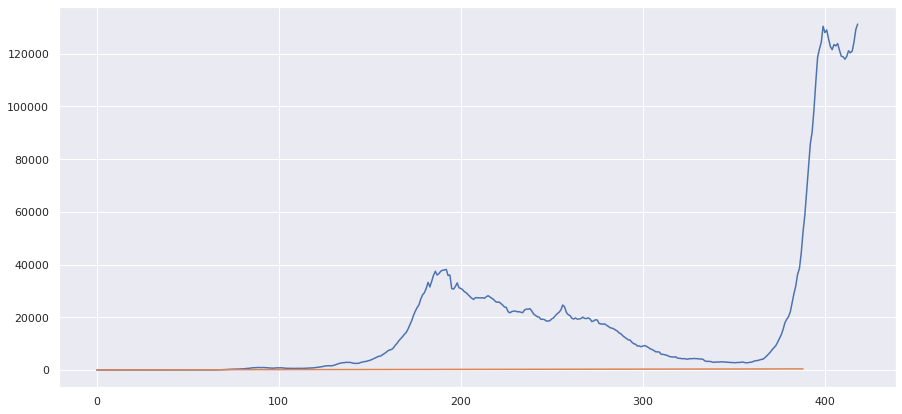

In [ ]:
plt.plot(active_cases['CT'])
plt.plot(active_cases['RJ'])

In [ ]:
active_cases['RJ']=active_cases['RJ'][30:]

In [ ]:
active_cases['RJ']=active_cases['RJ'].dropna()

In [ ]:
active_cases['RJ']=active_cases['RJ'].dropna().reset_index()

In [ ]:
active_cases['RJ']

0      30.0
1      31.0
2      32.0
3      33.0
4      34.0
       ... 
414     NaN
415     NaN
416     NaN
417     NaN
418     NaN
Name: RJ, Length: 419, dtype: float64